Here, we'll test how dynamically novel the components of the CST- and RTT-unique spaces are.

First, load the data and split the subspaces out:

In [2]:
#| output: false
import src
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

td = pd.read_pickle('../results/dekodec/Prez_20220721_dekodec_split.pkl')
td.columns

Index(['M1_spikes', 'M1_unit_guide', 'MC_spikes', 'MC_unit_guide',
       'PMd_spikes', 'PMd_unit_guide', 'bin_size', 'cst_cursor_command',
       'ct_location', 'cursor_pos', 'date_time', 'hand_pos', 'idx_cstEndTime',
       'idx_cstStartTime', 'idx_ctHoldTime', 'idx_endTime', 'idx_failTime',
       'idx_goCueTime', 'idx_pretaskHoldTime', 'idx_rewardTime',
       'idx_rtHoldTimes', 'idx_rtgoCueTimes', 'idx_startTime', 'lambda',
       'monkey', 'raw_left_eye_pos', 'raw_left_pupil', 'rel_cursor_pos',
       'rel_hand_pos', 'result', 'rt_locations', 'task', 'trial_id',
       'session_date', 'M1_rates', 'MC_rates', 'PMd_rates', 'lfads_rates',
       'lfads_inputs', 'hand_vel', 'hand_acc', 'cursor_vel', 'hand_speed',
       'Time from go cue (s)', 'Time from task cue (s)', 'trialtime',
       'lfads_rates_joint_pca', 'lfads_rates_joint_pca_cst_unique',
       'lfads_rates_joint_pca_rtt_unique', 'lfads_rates_joint_pca_shared',
       'lfads_rates_joint_pca_split'],
      dtype='object')

/Users/raeed/codebase/0-projects/cst-dynamics/src/decoder_analysis.py:53: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



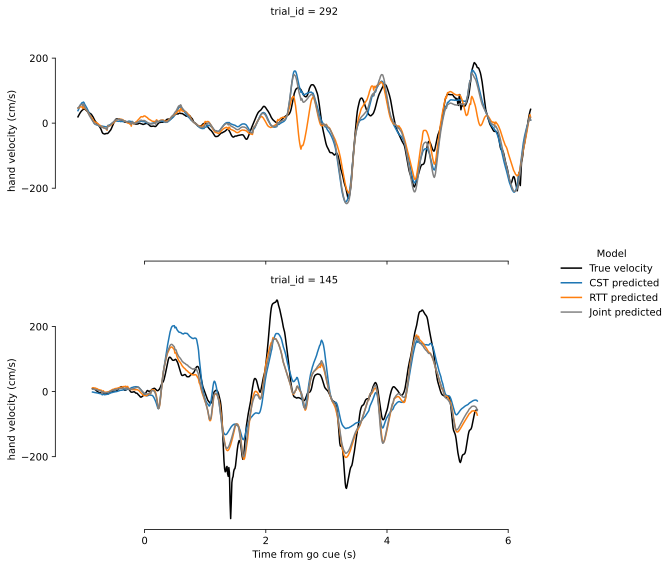

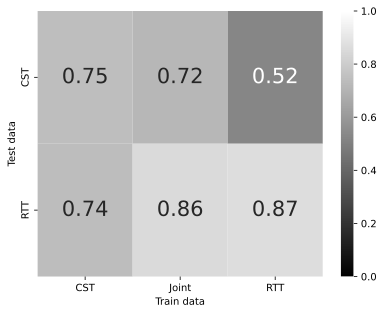

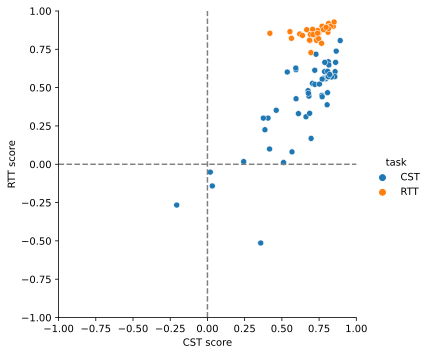

In [57]:
trial_fig, score_fig = src.decoder_analysis.run_decoder_analysis(
    td,
    'lfads_rates_joint_pca',
    hand_or_cursor='hand',
    pos_or_vel='vel',
    trace_component=0
)


Let's double-check that the split worked satisfactorily with a variance plot.

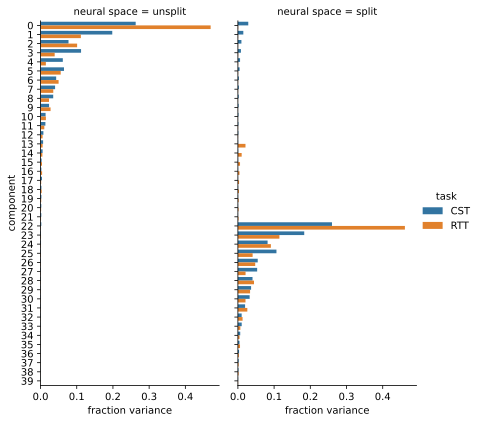

In [42]:
src.plot.plot_split_subspace_variance(td,signal='lfads_rates_joint_pca')

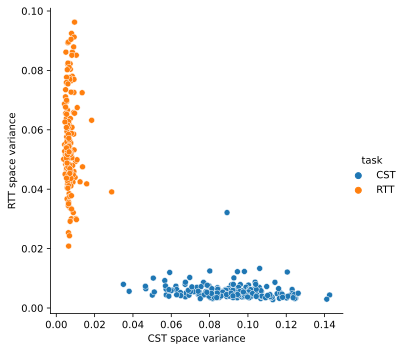

In [ ]:
src.plot.plot_single_trial_split_var(td,signal='lfads_rates_joint_pca')

/Users/raeed/codebase/0-projects/cst-dynamics/src/decoder_analysis.py:53: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



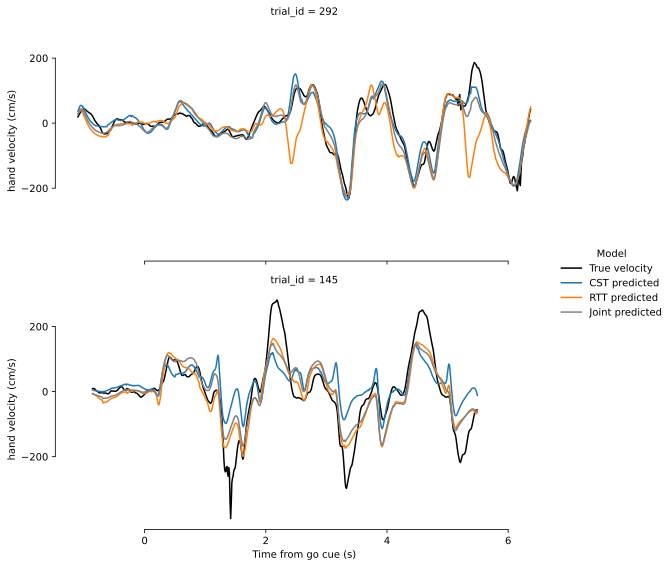

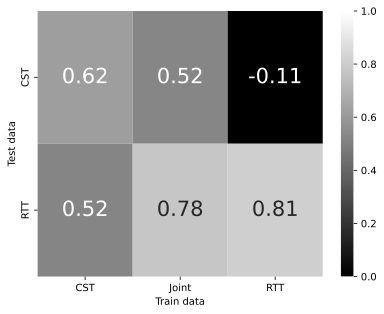

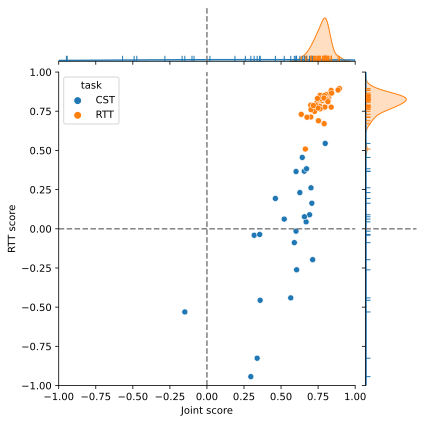

In [102]:
trial_fig, score_fig = src.decoder_analysis.run_decoder_analysis(
    td,
    'lfads_rates_joint_pca_shared',
    hand_or_cursor='hand',
    pos_or_vel='vel',
    trace_component=0,
)


/Users/raeed/codebase/0-projects/cst-dynamics/src/decoder_analysis.py:53: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



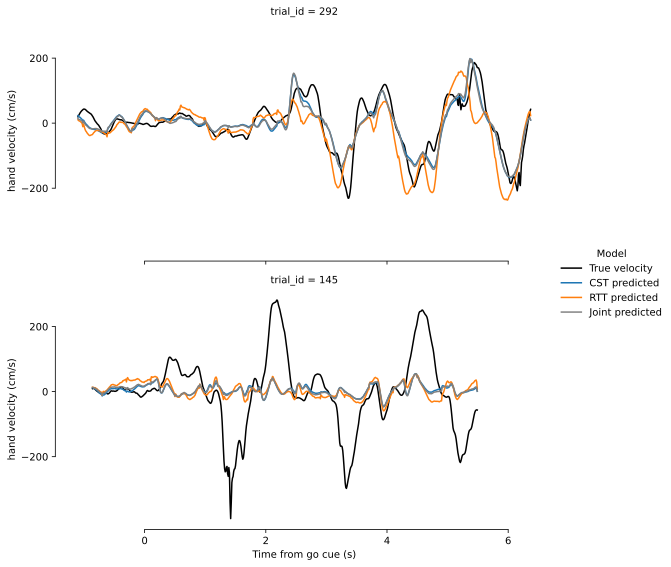

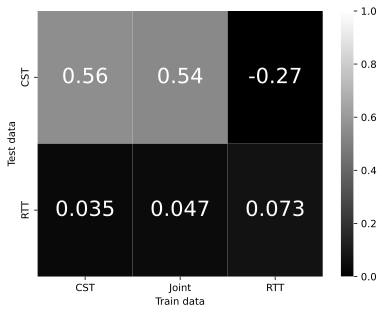

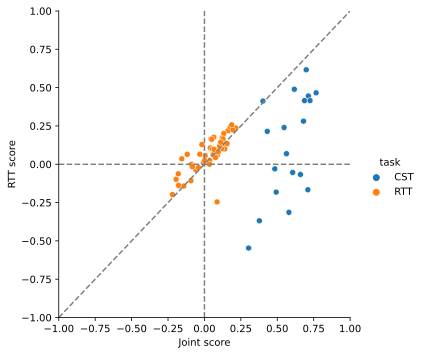

In [69]:
trial_fig, score_fig = src.decoder_analysis.run_decoder_analysis(
    td,
    'lfads_rates_joint_pca_cst_unique',
    hand_or_cursor='hand',
    pos_or_vel='vel',
    trace_component=0,
)


/Users/raeed/codebase/0-projects/cst-dynamics/src/decoder_analysis.py:53: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



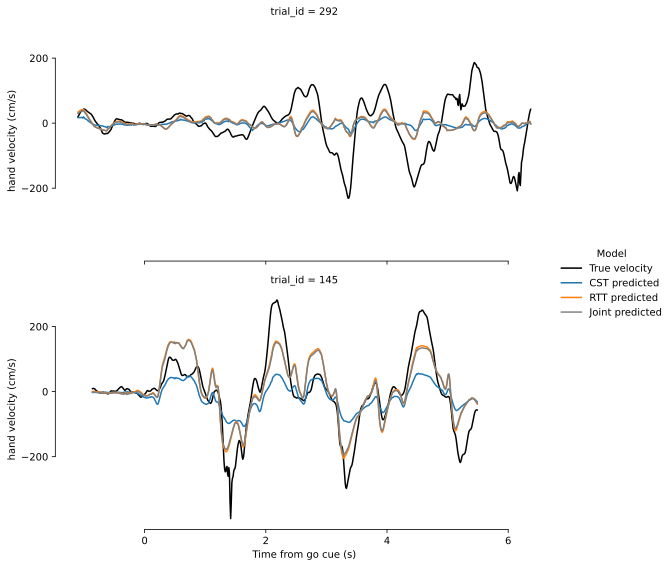

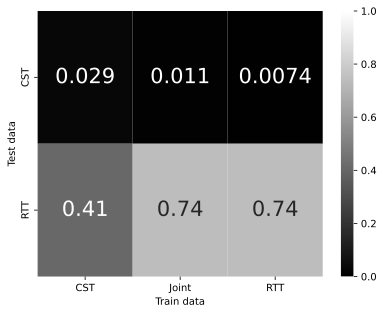

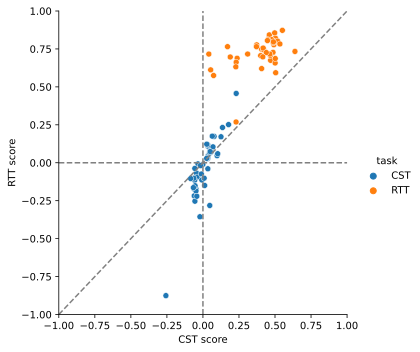

In [61]:
trial_fig, score_fig = src.decoder_analysis.run_decoder_analysis(
    td,
    'lfads_rates_joint_pca_rtt_unique',
    hand_or_cursor='hand',
    pos_or_vel='vel',
    trace_component=0,
)


In [65]:
import plotly.express as px

signal = 'lfads_rates_joint_pca_shared'
df = src.decoder_analysis.precondition_td(td, signal)
models = src.decoder_analysis.fit_models(df, signal)

trial_scores = src.decoder_analysis.score_trials(df.loc[df['Test set']],signal,models)

fig = px.scatter(
    trial_scores.reset_index(),
    x='CST score',
    y='RTT score',
    color='task',
    hover_data=['trial_id'],
    marginal_x='violin',
    marginal_y='violin',
    template='plotly_white',
    width=600,
    height=600,
    color_discrete_sequence=px.colors.qualitative.T10,
)
fig.show()

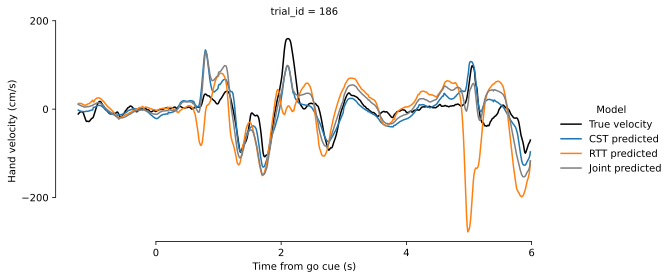

In [71]:
trials_to_plot = [186]
trial_pred = (
    df
    .set_index(['trial_id'])
    .loc[trials_to_plot]
    .pipe(src.decoder_analysis.model_predict, signal, models)
    .reset_index()
    .melt(
        id_vars=['trial_id','Time from go cue (s)','task'],
        value_vars=['True velocity','CST predicted','RTT predicted','Joint predicted'],
        var_name='Model',
        value_name='Hand velocity (cm/s)',
    )
)
g=sns.relplot(
    data=trial_pred,
    x='Time from go cue (s)',
    y='Hand velocity (cm/s)',
    hue='Model',
    hue_order=['True velocity','CST predicted','RTT predicted','Joint predicted'],
    palette=['k','C0','C1','0.5'],
    kind='line',
    row='trial_id',
    row_order=trials_to_plot,
    height=4,
    aspect=2,
)
g.axes[0,0].set_yticks([-200,0,200])
g.axes[0,0].set_xticks([0,2,4,6])
sns.despine(fig=g.fig,trim=True)

In [96]:
temp = (
    df
    .set_index(['trial_id'])
    .pipe(src.decoder_analysis.model_predict, signal, models)
    .assign(**{
        'CST residual': lambda df: -df['CST predicted'] + df['True velocity'],
        'RTT residual': lambda df: -df['RTT predicted'] + df['True velocity'],
        'Joint residual': lambda df: -df['Joint predicted'] + df['True velocity'],
    })
    .reset_index()
)
g = sns.relplot(
    data=temp.groupby('task').sample(10000),
    x='True velocity',
    y='Joint residual',
    kind='scatter',
    hue='task',
)
g.axes[0,0].set_xlim([-300,300])
g.axes[0,0].set_ylim([-300,300])
g.refline(x=0,y=0,linestyle='--',color='k')
g.ax.set_aspect('equal')
g.ax.plot([-300,300],[-300,300],linestyle='--',color='k')